# Testing degradation on ABC vs true distribution

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

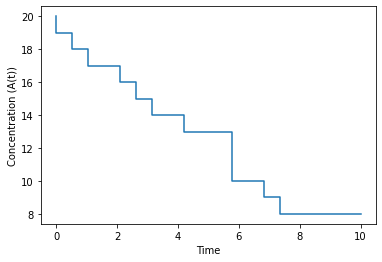

In [50]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('Time')
plt.ylabel('Concentration (A(t))')

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)


plt.savefig(my_path + '/degradation_model.pdf')

# res_kl_adaptive_pmc = resulting_kl

# plt.show()

In [3]:
np.random.seed(0)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 200)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=5.086995413811021e-16
posterior integrate value=0.9999392938746746


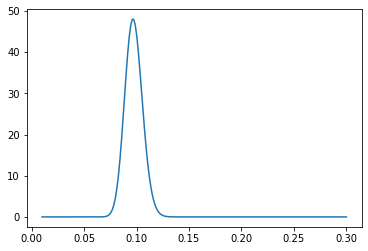

In [51]:
plt.plot(thetas, true_prob)

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)


plt.savefig(my_path + '/degradation_posterior.pdf')
# plt.show()

# Rejection ABC

In [22]:
error_thresholds = [9, 7, 5, 3, 2]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior)

        # set threshold
        abc.sampler().set_threshold(error)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        print('Running...')
        samples  = abc.run()
        print('Done')

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array([x for y in samples[:, 0] for x in y])

        inter_kl.append(kl_div(t_samples, 0.07, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 9
Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.0
2     2      1                0:00.0
3     3      1                0:00.0
20    21     0.952380952381   0:00.0
40    41     0.975609756      0:00.0
60    61     0.983606557377   0:00.1
80    81     0.987654321      0:00.1
100   101    0.990099009901   0:00.1
120   121    0.991735537      0:00.1
140   141    0.992907801      0:00.1
160   161    0.99378882       0:00.2
180   181    0.994475138      0:00.2
200   201    0.995024876      0:00.2
220   221    0.995475113      0:00.2
240   241    0.995850622      0:00.2
260   261    0.996168582      0:00.2
280   281    0.996441281      0:00.2
300   301    0.996677741      0:00.3
320   321    0.996884735      0:00.3
340   341    0.997067449      0:00.3
360   361    0.997229917      0:00.3
380   381    0.997375328084   0:00.3
400   401    0.997506234414   0:00.3
420   421    0.997624703      0:00.4

(10.0, 1.0)

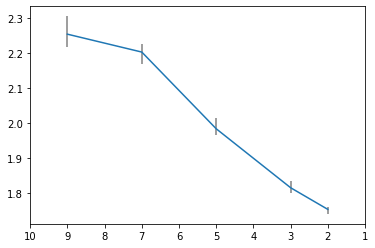

In [24]:
resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


fig, ax = plt.subplots()


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(10, 1)

res_kl_abc_rej = resulting_kl

# PMC Degradation (with smc)

In [28]:
error_thresholds = [9, 7, 5, 3, 2]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([error * 1.5, error * 1.3, error]))

        # produce intermediate distributions of size 1000
        abc.sampler().set_intermediate_size(500)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, 0.07, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 9
Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=11.700000000000001
Trying t=2, threshold=9.0
Iter. Eval. Acceptance rate Time m:s
1     1001   0.000999000999   0:07.2
2     1002   0.00199600798    0:07.2
3     1003   0.00299102692    0:07.2
20    1020   0.0196078431     0:07.2
40    1040   0.0384615385     0:07.2
60    1060   0.0566037736     0:07.2
80    1080   0.0740740741     0:07.3
100   1100   0.0909090909     0:07.3
120   1120   0.107142857      0:07.3
140   1140   0.122807018      0:07.3
160   1160   0.137931034      0:07.3
180   1180   0.152542373      0:07.3
200   1200   0.166666667      0:07.3
220   1220   0.180327869      0:07.4
240   1240   0.193548387      0:07.4
260   1260   0.206349206      0:07.4
280   1280   0.21875          0:07.4
300   1300   0.230769231      0:07.5
320   1320   0.242424242      0:07.5
340   1340   0.253731343      0:07.5
360   1360   0.264705882      0:07.5
380   1380   0.275362319      0:07.5
400   1401   0.28551035

[[2.18097462 2.23108235 2.23668804 2.19930171 2.23646574]
 [2.08890818 2.13350857 2.22872206 2.12669042 2.1473535 ]
 [1.93451699 1.95584231 1.92703676 1.95355995 1.93447528]
 [1.75873887 1.75630413 1.77158903 1.75773469 1.7625639 ]
 [1.722911   1.72253797 1.71910504 1.71803962 1.71832386]]
[9, 7, 5, 3, 2]


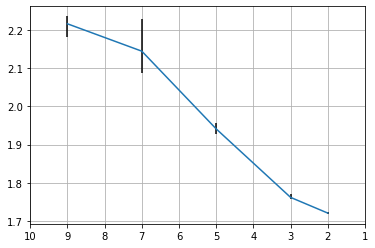

In [31]:
print(resulting_kl)
print(error_thresholds)


resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


fig, ax = plt.subplots()


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(10, 1)
plt.grid(True)

plt.show()
res_kl_true_pmc_rej = resulting_kl

# ABC SMC

In [34]:
error_thresholds = [9, 7, 5, 3, 2]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([error * 1.5, error * 1.3, error]))

        # produce intermediate distributions of size 1000
        abc.sampler().set_intermediate_size(100)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, 0.07, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 9
Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=11.700000000000001
Trying t=2, threshold=9.0
Iter. Eval. Acceptance rate Time m:s
1     201    0.00497512438    0:00.4
2     202    0.0099009901     0:00.4
3     203    0.0147783251     0:00.4
20    220    0.0909090909     0:00.4
40    240    0.166666667      0:00.4
60    260    0.230769231      0:00.5
80    280    0.285714286      0:00.5
100   300    0.333333333      0:00.6
120   320    0.375            0:00.6
140   340    0.411764706      0:00.6
160   360    0.444444444      0:00.6
180   380    0.473684211      0:00.6
200   400    0.5              0:00.6
220   420    0.523809524      0:00.7
240   440    0.545454545      0:00.7
260   460    0.565217391      0:00.7
280   480    0.583333333      0:00.8
300   500    0.6              0:00.8
320   520    0.615384615      0:00.8
340   540    0.62962963       0:00.8
360   560    0.642857143      0:00.8
380   581    0.65404475       0:00.8
400   601    0.66555740

[[2.2407468334382163, 2.151381045851961, 2.377911588932389, 2.281336804673031, 2.3115799331928812], [2.2094858267554196, 2.176207793578567, 2.211193915164362, 2.120280509688354, 2.1569763151070482], [1.9251989692390512, 1.9377903510734082, 1.913364177303197, 1.905745382659858, 1.9566312381885538], [1.7633362535115509, 1.7654169035805545, 1.80172975501437, 1.76968056758224, 1.7570813311641067], [1.7103818620569315, 1.7210066899753633, 1.7110709052776472, 1.723600688995675, 1.7120812553855016]]
[9, 7, 5, 3, 2]


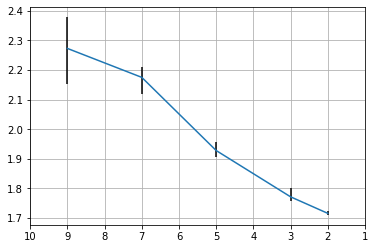

In [35]:
print(resulting_kl)
print(error_thresholds)

resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(10, 1)
plt.grid(True)

plt.show()
res_kl_fake_pmc_rej = resulting_kl

# Compare all algorithms errors

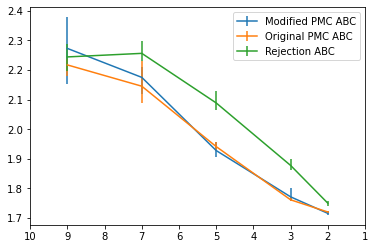

In [41]:

mins_fake_pmc_kl = res_kl_fake_pmc_rej.min(1)
maxes_fake_pmc_kl = res_kl_fake_pmc_rej.max(1)
means_fake_pmc_kl = res_kl_fake_pmc_rej.mean(1)

mins_true_pmc_kl = res_kl_true_pmc_rej.min(1)
maxes_true_pmc_kl = res_kl_true_pmc_rej.max(1)
means_true_pmc_kl = res_kl_true_pmc_rej.mean(1)

mins_abc_rej_kl = res_kl_abc_rej.min(1)
maxes_abc_rej_kl = res_kl_abc_rej.max(1)
means_abc_rej_kl = res_kl_abc_rej.mean(1)

plt.errorbar(error_thresholds, means_fake_pmc_kl, [means_fake_pmc_kl - mins_fake_pmc_kl, maxes_fake_pmc_kl - means_fake_pmc_kl], label='Modified PMC ABC')
plt.errorbar(error_thresholds, means_true_pmc_kl, [means_true_pmc_kl - mins_true_pmc_kl, maxes_true_pmc_kl - means_true_pmc_kl], label='Original PMC ABC')
plt.errorbar(error_thresholds, means_abc_rej_kl, [means_abc_rej_kl - mins_abc_rej_kl, maxes_abc_rej_kl - means_abc_rej_kl], label='Rejection ABC')

plt.xlim(10, 1)
plt.legend()

ax.plot(error_thresholds, res_kl_abc_rej, label='Rejection ABC')
ax.grid(True)
ax.legend()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/degradation_errors_all.pdf')

# Adaptive PMC ABC

In [45]:
error_thresholds = [0.5, 0.4, 0.3, 0.2]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

        # set threshold
        abc.sampler().set_N_l(300)

        # set p_acc_min
        abc.sampler().set_p_acc_min(error)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        print('Running...')
        samples  = abc.run()
        print('Done')

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, 0.07, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 0.5
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.12646922]
resulting var=[[0.00891194]]
epsilon=3.7815340802378077
w_mean=[0.12696524]
resulting var=[[0.00563817]]
epsilon=3.0
w_mean=[0.11410658]
resulting var=[[0.00352167]]
epsilon=2.3664319132398464
w_mean=[0.11512494]
resulting var=[[0.00348888]]
Iter. Eval. Acceptance rate Time m:s
1     5      100              0:54.4
Halting: target number of samples (500) reached.
Done
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.13282173]
resulting var=[[0.00713628]]
epsilon=3.4351128074635335
w_mean=[0.1183676]
resulting var=[[0.00577392]]
epsilon=2.701851217221259
w_mean=[0.10876982]
resulting var=[[0.00387926]]
Iter. Eval. Acceptance rate Time m:s
1     4      125.25           0:40.1
Halting: target number of samples (501) reached.
Done
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.12708945]
resulting var=[[0.00688492]]
epsilon=3.1304951684997055
w_

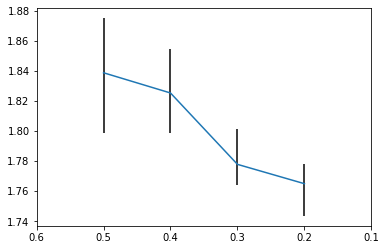

In [48]:
resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(0.6, 0.1)
# plt.grid(True)

# plt.show()


import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)


plt.savefig(my_path + '/degradation_errors_adaptive.pdf')

res_kl_adaptive_pmc = resulting_kl